## Generate a 2D image of maximum $z$ values from 3D point clouds

September 11, 2024

Jin-Hwan CHO (with the help of Seongwon Lee)

### Input

- 3D point cloud: `numpy.ndarray` of shape ($n$, 3)
- image size: `tuple[int, int]` ($k$, $l$)

### Output

- 2D image: `numpy.ndarray` of shape ($k$, $l$)
- Each 3D point of the cloud is allocated to the corresponding pixel in the 2D image by $x$ and $y$ values.
- The value of each pixel is the maximum $z$ value of the allocated 3D points.
- We assume the initial pixel value is zero when no 3D point is allocated to the pixel.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

sample_size = 100_000
image_size  = (50, 100)

rng = np.random.default_rng(0)
xy_points = rng.random((sample_size, 2))
z_points = multivariate_normal(
    mean=[0.5, 0.5], cov=np.identity(2)
).pdf(xy_points)
z_points += rng.standard_normal(sample_size) * 1e-3 # add noise

points = np.hstack((xy_points, z_points[:, np.newaxis]))
points.shape, image_size

((100000, 3), (50, 100))

### 1. Vanilla code using `for`

In [2]:
from itertools import product

def zmax_image_vanilla(
    points: np.array, image_size: tuple[int, int],
    z_init: float=0., eps: float=1e-5
) -> np.array:
    assert len(points.shape) == 2 and points.shape[1] == 3
    X, Y, Z = points.T

    assert len(image_size) == 2
    x_size, y_size = image_size

    # Construct x-bins and y-bins of size x_size and y_size, respectively.
    x_bins = np.linspace(X.min() - eps, X.max() + eps, x_size + 1)
    y_bins = np.linspace(Y.min() - eps, Y.max() + eps, y_size + 1)

    # Allocate X values to x-bins and Y values to y-bins, respectively.
    ix = np.digitize(X, x_bins) - 1
    iy = np.digitize(Y, y_bins) - 1

    # Vanilla code using for
    image = np.zeros(image_size)
    for i, j in product(range(x_size), range(y_size)):
        image[i, j] = np.max(Z[(ix == i) & (iy == j)], initial=z_init)

    return image

image_v = zmax_image_vanilla(points, image_size)

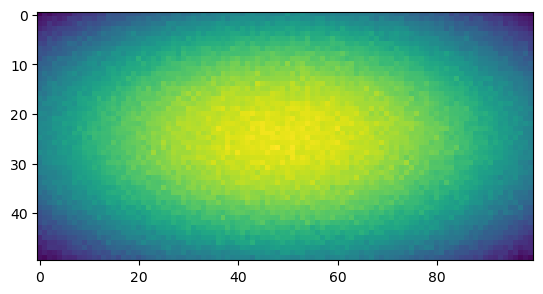

In [3]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(image_v)
pass

### 2. Efficient code using Seongwon Lee's idea

In [4]:
def zmax_image_efficient(
    points: np.array, image_size: tuple[int, int],
    z_init: float=0., eps: float=1e-5
) -> np.array:
    assert len(points.shape) == 2 and points.shape[1] == 3
    X, Y, Z = points.T

    assert len(image_size) == 2
    x_size, y_size = image_size

    # Construct x-bins and y-bins of size x_size and y_size, respectively.
    x_bins = np.linspace(X.min() - eps, X.max() + eps, x_size + 1)
    y_bins = np.linspace(Y.min() - eps, Y.max() + eps, y_size + 1)

    # Allocate X values to x-bins and Y values to y-bins, respectively.
    ix = np.digitize(X, x_bins) - 1
    iy = np.digitize(Y, y_bins) - 1

    # Efficient code using Seongwon Lee's idea
    #   1. Apply lexical (indirect) sort on xy-indices and z-values.
    ils = np.lexsort((Z, iy, ix))
    six = ix[ils]
    siy = iy[ils]
    sZ = Z[ils]
    #   2. Collect the differences of xy-indices on which z-value is the maximum.
    inz = np.nonzero(np.diff(six) + np.abs(np.diff(siy)))[0]
    inz = np.append(inz, ils.shape[0] - 1) # add the last index
    #   3. Fill maximum z-values in the image
    image = np.full(image_size, z_init)
    image[six[inz], siy[inz]] = sZ[inz]

    return image

image_e = zmax_image_efficient(points, image_size)

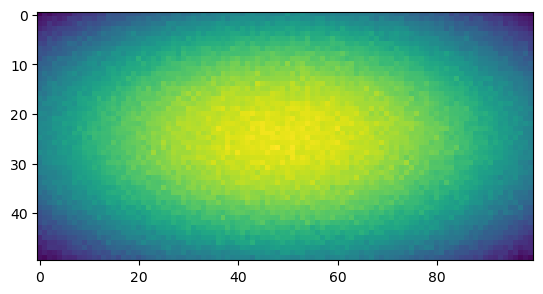

In [5]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(image_e)
pass

### 3. Verify that two images are the same

In [6]:
np.allclose(image_v, image_e)

True

### 4. Compare the calculation time

In [7]:
image_size = (100, 100)

%timeit zmax_image_vanilla(points, image_size)
%timeit zmax_image_efficient(points, image_size)

689 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.7 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
image_size = (200, 200)

%timeit zmax_image_vanilla(points, image_size)
%timeit zmax_image_efficient(points, image_size)

2.68 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
28.4 ms ± 266 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
image_size = (500, 500)

%timeit zmax_image_vanilla(points, image_size)
%timeit zmax_image_efficient(points, image_size)

15.8 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.2 ms ± 638 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
